In [1]:
import numpy as np
import crispr_assembler as ca
import matplotlib.pyplot as plt
import editdistance as ed
import os
import pickle

import tqdm


%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
def get_weights(gr, arrays):
    weights = []
    for a in arrays:
        w = []
        for x, y in zip(a, a[1:]):
            w.append(gr[x, y])
        weights.append(w)
    
    return weights

In [5]:
def get_routes(graph, route, routes, vertex):
    candidates = np.where(graph[vertex] > 0)[0]
    #print(candidates)
    if len(candidates) == 0:
        #print("a", routes)
        routes.append(route)
    else:
        is_final = 1
        for candidate in candidates:
            if not candidate in route:
                is_final = 0
                new_route = [x for x in route]
                new_route.append(candidate)
                #print('n', new_route)
                get_routes(graph, new_route, routes,candidate)
        if is_final:
            #print("a", routes)
            routes.append(route)

In [6]:
def restore_all(graph):
    start_vertexes = np.where(graph.sum(0) == 0)[0]
    
    answ = []
    
    for vertex in start_vertexes:
        routes = []
        route = [vertex]
        get_routes(graph, route, routes, vertex)
        
        answ.extend(routes)
        
    return answ

In [7]:
def make_vertexes_embs(gr):
    embs = np.zeros((gr.flatten().shape[0], 5))
    
    for i in range(embs.shape[0]):
        x, y = i // gr.shape[0], i % gr.shape[0]
        #print(x, y)
        embs[i, 0] = gr[x, y]
        embs[i, 1] = embs[i, 0] /  max(1, gr[x].sum())
        embs[i, 2] = embs[i, 0] /  max(1,gr[:, y].sum())
        
        embs[i, 3] = embs[i, 0] / max(1, gr[:, x].sum())
        embs[i, 4] = embs[i, 0] / max(1, gr[y].sum())
    return embs

In [8]:
def calc_metrics_2(gr, gr_r, a):
    spacers = np.array(sorted(list(set([x for x in range(gr_r.shape[0])] + ca.unwrap_nested(a)))))

    reference_gr = (ca.graph_from_arrays(a, len(spacers))[0] > 0).astype(int)
    restored_gr = gr_r[spacers][:, spacers]#(ca.graph_from_arrays(r, len(spacers))[0] > 0).astype(int)
    
    return roc_auc_score(reference_gr.flatten(), restored_gr.flatten()), \
            f1_score(reference_gr.flatten(), restored_gr.flatten()), \
            precision_score(reference_gr.flatten(), restored_gr.flatten()), \
            recall_score(reference_gr.flatten(), restored_gr.flatten())
            
            
    

In [13]:
def do_all_2(f_name, res, answ):
    gr = res.graph_from_pairs()[0]
    embs= make_vertexes_embs(gr.astype(float))
    pred = gb.predict(embs[:, 1:]).reshape(gr.shape)
    print(f_name)
    #r, w = ca.restore_arrays(res[1][0], 5)
    a, d = ca.multiple_arrays_to_ids(answ, res.spacer_to_cluster_index)
    
    print(" & ".join(map(lambda x : "{0:.3f}".format(x), calc_metrics_2(gr, pred, [x for x in a.values()]))))
    
    return pred
    #return r, w, a, d, calc_metrics(res[1][0], r, [x for x in a.values()])

In [28]:
path = '/home/anton/BigMac/skoltech/CRISPR_research/article/old_as_new/gz/'
folders = sorted(os.listdir(path))

In [15]:
answer_all = ca.read_arrays_with_tags("../../article/data/answers/all_refresh", 0)

In [16]:
answer_sensivity = ca.read_arrays_with_tags("../../article/data/answers/sensivity", 0)

In [20]:
keys_1 = ['first_8', 'second_8']

keys_2 = ['first_8', 'second_8', 'first_50', 'second_50']

keys_10 = ['first_2', 'first_3', 'first_5', 'first_7',
        'first_8', 'first_21', 'first_27', 'first_65', 
        'first_9', 'first_12', 
        'second_2',  'second_5',  'second_21', 'second_65',
        'second_3', 'second_7', 'second_8', 'second_27',
        'second_9', 'second_12']

In [21]:
answer_all.keys()

dict_keys(['first_1', 'first_11', 'first_2', 'first_24', 'first_61', 'first_62', 'first_68', 'first_3', 'first_5', 'first_50', 'first_7', 'first_8', 'first_14', 'first_15', 'first_19', 'first_20', 'first_22', 'first_31', 'first_21', 'first_23', 'first_27', 'first_65', 'first_70', 'first_9', 'first_12', 'first_66', 'first_67', 'second_1', 'second_2', 'second_61', 'second_62', 'second_68', 'second_5', 'second_50', 'second_21', 'second_65', 'second_70', 'second_3', 'second_7', 'second_8', 'second_11', 'second_14', 'second_15', 'second_19', 'second_20', 'second_22', 'second_23', 'second_24', 'second_27', 'second_31', 'second_9', 'second_12', 'second_66', 'second_67'])

In [22]:
def generate_answer(answer_all, keys):
    answ = {}

    for key in keys:
        answ[key] = answer_all[key]
    return answ

In [23]:
answ_1, answ_2, answ_10 = [generate_answer(answer_all, x) for x in [keys_1, keys_2, keys_10]]

In [29]:
answers = [answ_1, answ_2,answer_sensivity]

# Calc answ

In [30]:
def restore(path, minimum_occurences = 0):
    read = ca.Read(path)
    read.correct_errors(minimum_occurences = minimum_occurences)
    #gr = read.graph_from_pairs()

    return read#, gr

In [31]:
folders[:5]

['ES1', 'ES3', 'sensivity']

In [32]:
#res = [restore("../../article/newdata/r5/out/pairs/Anton_R5_S51_R1_001.fastq.gz_pairs.txt")]
res = []

for folder in folders[:5]:
    files = os.listdir(path + folder + "/out/pairs")
    res.append(restore(path + folder + "/out/pairs/" + files[0], 5))

100%|██████████| 1040/1040 [00:00<00:00, 2874.21it/s]


In [33]:
answers_ids = []

for a, r in zip(answers, res):
    answers_ids.append(ca.multiple_arrays_to_ids(a, r.spacer_to_cluster_index))

100%|██████████| 20/20 [00:00<00:00, 38.66it/s]


In [34]:
for a, a_sp in zip(answers_ids[:], answers[:]):
    seen = []
    good_distances = 0
    
    for k in a[0].keys():
        for dist, spacer in zip (a[1][k], a_sp[k]):
            
            if ca.find_closest(seen, spacer)[0] > 6:
                seen.append(spacer)
                if dist < 5:
                    good_distances += 1
            else:
                #print("seen", spacer, k)
                pass
    
                
    print(good_distances, len(seen), good_distances / len(seen))
    #ca.unwrap_nested([x for x in a[1].values()])
    #print([x < 5 for x in ca.unwrap_nested([x for x in a[1].values()])])
    #print(sum([x < 5 for x in ca.unwrap_nested([x for x in a[1].values()])]), len(ec.cluster_to_index))
    #[x ca.unwrap_nested([x for x in a[1].values()]) 

16 18 0.8888888888888888
17 20 0.85
130 144 0.9027777777777778


In [35]:
answers_ids[1]

({'first_8': [22, 18, 19, 4, 29, 23, 27, 26, 30, 31, 32, 33],
  'second_8': [1, 21, 0, 28, 20, 25],
  'first_50': [22, 18, 19, 24, 0, 4, 29, 23, 27, 26, 30],
  'second_50': [1, 21, 0, 28, 20, 25]},
 {'first_8': [0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 1],
  'second_8': [0, 0, 14, 0, 0, 1],
  'first_50': [0, 0, 0, 0, 13, 12, 0, 0, 0, 0, 0],
  'second_50': [1, 1, 15, 1, 2, 2]})

In [36]:
answer_ids_fixed = []

for a in answers_ids[:]:
    new_dict = {}
    
    m = max(ca.unwrap_nested([x for x in a[0].values()]))
    print(m)
    for k in a[0].keys():
        mask = np.array([x > 5 for x in a[1][k]])
        new_array = np.array(a[0][k])
        new_array[mask] = m + 1
        
        new_dict[k] = new_array
    
    answer_ids_fixed.append((new_dict, a[1]))

17
33
136


In [38]:
answer_ids_fixed[2]

({'first_11': array([117,  80,  61,  72,  62,  51,  44]),
  'first_2': array([ 92, 137, 129,  91,  76]),
  'first_3': array([ 91,  76,  68,  67,  84, 101, 109]),
  'first_5': array([88, 36, 31, 40, 45, 49, 41, 48, 59, 63, 90]),
  'first_7': array([42, 34, 29, 18, 35, 32, 24, 25, 39]),
  'first_8': array([ 88,  36,  31,  49,  41,  48,  59,  63,  90, 130, 131, 136]),
  'first_14': array([ 74,  38,  26,  21,   8,  14, 119,   9,   3,   1,   0,   2]),
  'first_15': array([117,  80,  61,  66,  72,  62,  52,  56,  53,  50,  51,  44,  47,
          54,  57,  55,  60,  70,  93]),
  'first_22': array([74, 38, 26, 21,  8, 14,  3,  4]),
  'first_21': array([ 92, 106, 105, 121, 118, 110, 116, 115, 128, 137, 137]),
  'second_2': array([ 28, 125, 120, 122, 123, 124, 127, 133, 137]),
  'second_5': array([ 79,  81, 137,  58,  46,  75]),
  'second_21': array([102,  79,  87,  83,  85, 108, 113, 114, 132, 137]),
  'second_3': array([111, 103,  94,  95,  97,  98, 104, 112]),
  'second_7': array([102,  87, 

In [39]:
grs = [x.graph_from_pairs()[0] for x in tqdm.tqdm(res)]

100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


In [40]:
[x.shape for x in grs]

[(19, 19), (36, 36), (138, 138)]

In [28]:
cuts = [17, 18, 18, 200, 200]

In [29]:
grs = [x[:c, :c] for x, c in zip(grs, cuts)]

In [30]:
[x.shape for x in grs]

[(17, 17), (18, 18), (18, 18), (136, 136), (189, 189)]

In [81]:
gb = pickle.load(open("./linear_svc_rep_to_rep", "rb"))
#gb = pickle.load(open("./lr_rep_to_rep", "rb"))

In [42]:
ec = ca.EmbeddingsCalculator()

In [43]:
embs = []
for gr in tqdm.tqdm(grs):
    ec = ca.EmbeddingsCalculator()
    embs.append(ec.fit_predict(gr))

100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


In [82]:
pred_grs = [gb.predict(emb).reshape(gr.shape) for emb, gr in zip(embs, grs)]

In [83]:
answer_grs = [ca.graph_from_arrays([list(x) for x in a[0].values()])[0] for a in answer_ids_fixed]

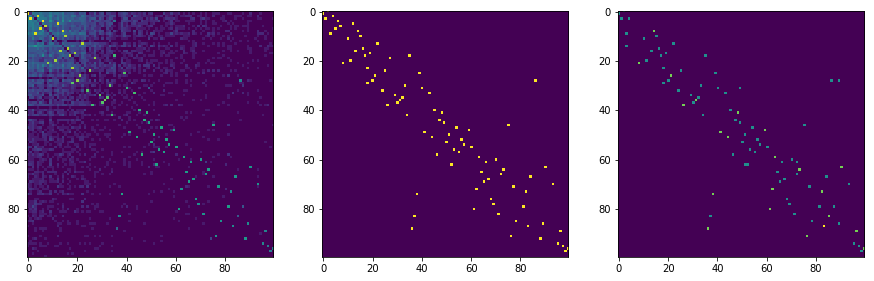

In [84]:
ind = 2
ca.plot_grs(grs[ind][:100, :100], pred_grs[ind][:100, :100], answer_grs[ind][:100, :100],  log=1, s =15)

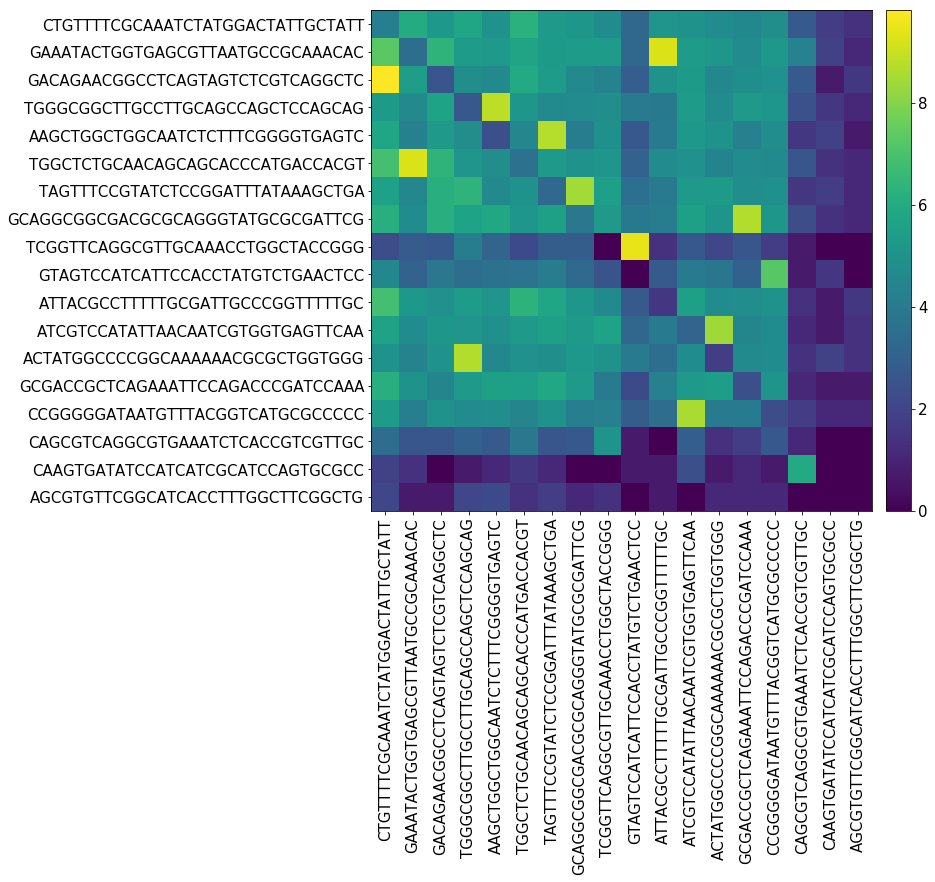

In [698]:
ind = 2
ca.plot_gr(grs[ind][:100, :100],  log=1, s =15, idx_to_sp=res[ind].index_to_cluster)

In [47]:
from sklearn.metrics import f1_score, precision_score, recall_score

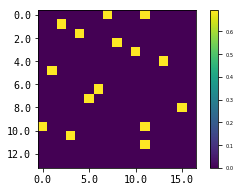

In [38]:
ca.plot_gr((grs[0] > 1000) > 0, log = 1, s = 5)

In [48]:
grs_threshold = [(x > 1000) > 0 for x in grs]

In [85]:
for p, a in zip(pred_grs, answer_grs):
    shape = (max(p.shape[0], a.shape[0]), max(p.shape[0], a.shape[0]))
    
    new_p, new_a = np.zeros(shape), np.zeros(shape)
    
    new_p[:p.shape[0], :p.shape[1]] = p
    new_a[:a.shape[0], :a.shape[1]] = a

    print(f1_score((new_a > 0).flatten(), new_p.flatten()), 
          precision_score((new_a > 0).flatten(), new_p.flatten()),
          recall_score((new_a > 0).flatten(), new_p.flatten()))

0.888888888888889 0.8 1.0
0.0 0.0 0.0
0.9149797570850201 0.9186991869918699 0.9112903225806451


/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [50]:
pred_grs_greedy = [ca.graph_from_arrays(ca.restore_arrays_greedy(gr)[0])[0] for gr in grs]

In [51]:
for p, a in zip(pred_grs_greedy, answer_grs):
    shape = (max(p.shape[0], a.shape[0]), max(p.shape[0], a.shape[0]))
    
    new_p, new_a = np.zeros(shape), np.zeros(shape)
    
    new_p[:p.shape[0], :p.shape[1]] = p
    new_a[:a.shape[0], :a.shape[1]] = a

    print(f1_score((new_a > 0).flatten(), new_p.flatten()), 
      precision_score((new_a > 0).flatten(), new_p.flatten()),
      recall_score((new_a > 0).flatten(), new_p.flatten()))

0.8571428571428571 0.75 1.0
0.0 0.0 0.0
0.8861788617886179 0.8934426229508197 0.8790322580645161


/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [52]:
grs_threshold = [(x > 650) > 0 for x in grs]
for p, a in zip(grs_threshold, answer_grs):
    shape = (max(p.shape[0], a.shape[0]), max(p.shape[0], a.shape[0]))
    
    new_p, new_a = np.zeros(shape), np.zeros(shape)
    
    new_p[:p.shape[0], :p.shape[1]] = p
    new_a[:a.shape[0], :a.shape[1]] = a

    print(f1_score((new_a > 0).flatten(), new_p.flatten()), 
      precision_score((new_a > 0).flatten(), new_p.flatten()),
      recall_score((new_a > 0).flatten(), new_p.flatten()))

0.8 0.7692307692307693 0.8333333333333334
0.0 0.0 0.0
0.37500000000000006 0.8333333333333334 0.24193548387096775


/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [47]:
arrs = [x for x in ca.restore_arrays_all(pred_grs[3])[0] if len(x) > 2]

In [53]:
test_arrays = [[2,4,5], [3,4,6,5], [0,1,2,3], [-1,2,3,4]]

In [53]:
def process_alignment(alignment, v =0):
    
    def upd_back(s, init_s, i):
        if i >= 0:
            s.insert(0, init_s[i])
        else:
            s.insert(0, '-')
            
    def upd_frwd(s, init_s, i):
        if i < len(init_s):
            s.append(init_s[i])
        else:
            s.append('-')
    
    init_seq = alignment[0]
    init_target = alignment[1]
    
    seq = alignment[2]
    target = alignment[3]
    
    back_ind = 1
    seq_pos = alignment[4]
    target_pos = alignment[6]
    while seq_pos - back_ind >= 0 or target_pos - back_ind >= 0:
        if v: print("b", seq, target, init_seq, init_target, seq_pos, back_ind)
        upd_back(seq, init_seq, seq_pos - back_ind)
        upd_back(target, init_target, target_pos - back_ind)
        back_ind += 1
    
    forward_ind = 0
    seq_pos = alignment[5]
    target_pos = alignment[7]
    while seq_pos + forward_ind < len(init_seq) or target_pos + forward_ind < len(init_target):
        if v: print("f", seq, target, init_seq, init_target, seq_pos, forward_ind)
        upd_frwd(seq, init_seq, seq_pos + forward_ind)
        upd_frwd(target, init_target, target_pos + forward_ind)
        forward_ind += 1
        
    
    return seq, target

In [54]:
def preprint_seq(seq, cell_size = 4):
    #seq_str = ['-'] * (start - min_border) + [str(x) for x in seq] + ['-'] * (max_border - end)
    #print(seq_str)
    return ''.join([' ' + str(el) + ' ' * (cell_size - len(str(el)) - 1) + ',' for el in seq])
    #return '[' + '  '.join(seq_str_allign)+"]"


In [55]:
def process_alignments(alignments):
#     aligned_seqs = []

#     for x in alignments:
#         pa = process_alignment(x)
#         aligned_seqs.append(pa)
        
    return [process_alignment(x) for x in alignments]

In [56]:
def preprint_multiple_alignment(pa, v=0):
    def check_pointers(pointers, pa):
        return any([x < len(y[0]) for x, y in zip(pointers, pa)])
    
    pointers = np.zeros(len(pa)).astype(int)
    seq = []
    targets = [[] for i in range(len(pa))]
    
    stop = 0
    while check_pointers(pointers, pa) and stop < 100:
        curr_symbols_seq = []
        for x, p in zip(pa, pointers):
            if p < len(x[0]):
                curr_symbols_seq.append(x[0][p])
            else:
                curr_symbols_seq.append('end')
        
        #curr_symbols_seq = [x[0][p] for x, p in zip(pa, pointers)]
        
        mask = [x == '-' for x in curr_symbols_seq]
        if any(mask):
            seq.append('-')
            for i in range(len(targets)):
                if mask[i] and pointers[i] < len(pa[i][1]):
                    targets[i].append(pa[i][1][pointers[i]])
                else:
                    targets[i].append('-')
            
            pointers[mask] += 1

        else:
            if len(set(curr_symbols_seq)) == 1:
                seq.append(curr_symbols_seq[0])
                
                for i in range(len(targets)):
                    if pointers[i] < len(pa[i][1]):
                        targets[i].append(pa[i][1][pointers[i]])
                    else:
                        targets[i].append('-')
                
                pointers += 1
            else:
                print("asasas", seq, curr_symbols_seq)
                
        if v:
            print(preprint_seq(seq))
            for x in targets:
                print(preprint_seq(x))

            print(pointers, [len(x[0]) for x in pa], )
            print("-----")

        stop += 1
        
        
    return seq, targets

In [57]:
def recalc_borders(alignment):#, seq, seq_i, seq_j, alg_i, alg_j):
    #recalc_borders(align[1], seq, align[4], align[5], align[6], align[7])
    return alignment[4] - alignment[6], (len(alignment[1]) - alignment[7]) + alignment[5]

In [58]:
test_arrays = [[2,4,5], [3,4,6,5], [0,1,2,3], [0,2,3,4], [3,4,5,6,7,8]]
alignments = ca.water_alignments([1,2,3,4,5], test_arrays)
aligned_seqs = process_alignments(alignments)
s, t =  preprint_multiple_alignment(aligned_seqs)

In [59]:
print(preprint_seq(s))
for t_ in t:
    print(preprint_seq(t_))

 -  , 1  , 2  , 3  , 4  , -  , 5  , -  , -  , -  ,
 -  , -  , 2  , -  , 4  , -  , 5  , -  , -  , -  ,
 -  , -  , -  , 3  , 4  , 6  , 5  , -  , -  , -  ,
 0  , 1  , 2  , 3  , -  , -  , -  , -  , -  , -  ,
 -  , 0  , 2  , 3  , 4  , -  , -  , -  , -  , -  ,
 -  , -  , -  , 3  , 4  , -  , 5  , 6  , 7  , 8  ,


In [60]:
test_arrays = [[ 38 , 21 , 104, 75 , 55 , 85 ], [ 38 , 62 , 21 , 90 , 109]]
alignments = sorted(ca.water_alignments([39 , 38 , 62 , 21 , 104, 75 , 55 , 85 , 131], test_arrays),
                    key = lambda x: x[-1])[::-1]

aligned_seqs = process_alignments(alignments)
s, t =  preprint_multiple_alignment(aligned_seqs)

print(preprint_seq(s))
for t_ in t:
    print(preprint_seq(t_))

 39 , 38 , 62 , 21 , 104, 75 , 55 , 85 , 131,
 -  , 38 , -  , 21 , 104, 75 , 55 , 85 , -  ,
 -  , 38 , 62 , 21 , 90 , 109, -  , -  , -  ,


In [61]:
def calculate_coverage(s, ts):
    score = 0
    for i in range(len(s)):
        for j in range(len(ts)):
            if s[i] == ts[j][i] and s[i] != "-": 
                #print(i, j )
                score+=1
                break
    return score / sum([x != '-' for x in s])

In [62]:
def calculate_iou(s, t):
    common = 0
    total = 0
    for i in range(len(s)):
        if s[i] == t[i]:
            if s[i] != '-':
                common += 1
                total += 1
        else:
            if s[i] != '-' and t[i] != '-':
                total += 2
            else:
                total += 1
                
    return common / total#, common, total
                

In [63]:
def calculate_mean_iou(s, ts):
    return np.mean([calculate_iou(s, t_) for t_ in ts])

In [64]:
print(preprint_seq(s))
for t_ in t:
    print(preprint_seq(t_))

 39 , 38 , 62 , 21 , 104, 75 , 55 , 85 , 131,
 -  , 38 , -  , 21 , 104, 75 , 55 , 85 , -  ,
 -  , 38 , 62 , 21 , 90 , 109, -  , -  , -  ,


In [150]:
calculate_mean_iou(s, t)


0.2441197691197691

In [112]:
v = answer_ids_fixed[3][0]['second_2']

In [113]:
allignments = ca.water_alignments(v, arrs)

In [114]:
allignments

array([[array([ 39,  38,  62,  21, 104,  75,  55,  85, 131]),
        list([38, 21, 104, 75, 55, 85]),
        list([38, 62, 21, 104, 75, 55, 85]),
        list([38, '-', 21, 104, 75, 55, 85]), 1, 8, 0, 6,
        0.7777777777777778, 1.0, 50.0],
       [array([ 39,  38,  62,  21, 104,  75,  55,  85, 131]),
        list([38, 62, 21, 90, 109]), list([38, 62, 21]),
        list([38, 62, 21]), 1, 4, 0, 3, 0.3333333333333333, 0.6, 30.0],
       [array([ 39,  38,  62,  21, 104,  75,  55,  85, 131]),
        list([38, 62, 21, 104, 75, 55, 85]),
        list([38, 62, 21, 104, 75, 55, 85]),
        list([38, 62, 21, 104, 75, 55, 85]), 1, 8, 0, 7,
        0.7777777777777778, 1.0, 70.0]], dtype=object)

## Water alignments

In [100]:
arrs

[[5, 27, 41],
 [24, 2, 4, 10, 69, 66, 52, 79, 84, 23, 0, 57, 64, 46, 87],
 [24, 2, 4, 48, 73, 56, 10, 69, 66, 52, 79, 84, 23, 0, 57, 64, 46, 87],
 [38, 21, 90, 109],
 [38, 21, 104, 75, 55, 85],
 [38, 62, 21, 90, 109],
 [38, 62, 21, 104, 75, 55, 85],
 [39, 68, 43, 37, 54, 51, 50, 125],
 [39, 68, 116, 43, 37, 54, 51, 50, 125],
 [39, 102, 106, 119, 122, 114, 112, 113],
 [53, 31, 36, 19, 47],
 [86, 60, 16, 12, 58],
 [86, 60, 118, 97, 65, 49, 82],
 [95, 3, 35],
 [95, 3, 80, 117],
 [98, 71, 72, 40, 59],
 [105, 91, 74, 60, 16, 12, 58],
 [105, 91, 74, 60, 118, 97, 65, 49, 82],
 [121, 115, 70, 28, 32, 44, 13, 29, 76, 67, 96],
 [123, 15, 1, 30, 89, 81, 83, 103, 110],
 [123, 15, 1, 78, 99],
 [124, 45, 18, 33, 9, 7, 26, 22, 14, 8, 6, 11, 34, 88],
 [127, 77, 94, 93, 92, 20, 17, 25, 42],
 [128, 120, 111, 107, 101, 100, 108, 126]]

In [112]:
answer_ids_fixed[3][0].values()

dict_values([array([123,  15,   1,  30]), array([  1,  30,  89,  81,  83, 103, 110]), array([129,  61,  63, 121, 115,  70,  28,  32,  44,  13,  29]), array([105,  91,  74,  60, 118,  97,  65,  49,  82]), array([129,  61,  63,  70,  28,  32,  44,  13,  29,  76,  67,  96]), array([127,  77,  94,  93,  92,  20,  17,  25,  42, 132, 132]), array([124,  45,  18,  33,   9,   7,  26,  22,  14,   8,   6,  11,  34,
        88]), array([127,  77,  94,  93,  92,  20,  17,  25,  42, 132]), array([98, 71, 72, 40, 59]), array([15,  1, 78, 99]), array([ 39,  38,  62,  21, 104,  75,  55,  85, 131]), array([  3,  35, 132,   5,  27,  41]), array([ 95,   3,  80, 117,  53,  31,  36,  19,  47, 132]), array([ 95,   3,  80, 117,  53,  31,  36,  19,  47, 132]), array([128, 120, 111, 107, 101, 100, 108, 126]), array([ 95,  80, 117,  24,   2,   4,  10]), array([  3,  35, 132,   5,  27,  41]), array([ 50, 132,  86,  60,  16,  12,  58]), array([ 95,  80, 117,  24,   2,   4,  48,  73,  56,  10,  69,  23,   0,
     

In [113]:
for a, b in zip ( ca.get_weights(grs[3], answer_ids_fixed[3][0].values()),
                 [np.std(x) / np.mean(x) for x in  ca.get_weights(grs[3], answer_ids_fixed[3][0].values())]):
    print(b)
    print(a)

0.5432339818196299
[374, 1859, 1115]
0.478087778069381
[1115, 551, 398, 549, 377, 331]
0.8301356492483167
[12, 2063, 77, 262, 198, 855, 1119, 854, 721, 1620]
0.3694195145616968
[428, 383, 559, 424, 163, 438, 771, 694]
0.6857447115475528
[12, 2063, 98, 855, 1119, 854, 721, 1620, 548, 661, 622]
0.8238908107789495
[274, 792, 207, 580, 421, 1558, 1047, 1140, 0, 0]
0.33617360706301436
[225, 1191, 1119, 872, 1649, 1037, 1156, 987, 1383, 1309, 1636, 1145, 625]
0.7147842060911778
[274, 792, 207, 580, 421, 1558, 1047, 1140, 0]
0.2024465308643079
[637, 557, 725, 945]
0.6036206771168506
[1859, 712, 458]
0.5171688246749953
[470, 681, 820, 459, 251, 848, 662, 4]
0.8481077924949717
[1325, 0, 0, 2063, 1852]
0.6576701022626563
[623, 1136, 261, 104, 1190, 792, 1064, 1367, 0]
0.6576701022626563
[623, 1136, 261, 104, 1190, 792, 1064, 1367, 0]
0.3009270593862407
[130, 284, 267, 317, 380, 377, 202]
0.91768709927558
[40, 261, 117, 1809, 1632, 796]
0.8481077924949717
[1325, 0, 0, 2063, 1852]
0.82845552450465

In [106]:
for a, b in zip ( ca.get_weights(grs[3], arrs), [np.std(x) / np.mean(x) for x in  ca.get_weights(grs[3], arrs)]):
    print(b)
    print(a)

0.05389527458492976
[2063, 1852]
0.44237857002868064
[1809, 1632, 796, 619, 699, 661, 698, 441, 699, 1390, 777, 702, 686, 882]
0.4433773509655227
[1809, 1632, 602, 824, 509, 750, 619, 699, 661, 698, 441, 699, 1390, 777, 702, 686, 882]
0.13759048667612603
[604, 489, 436]
0.35486003637895075
[604, 459, 251, 848, 662]
0.2527690613070553
[681, 820, 489, 436]
0.33537228430235594
[681, 820, 459, 251, 848, 662]
0.34508712374166733
[471, 504, 751, 991, 586, 776, 290]
0.47953848179669184
[471, 207, 289, 751, 991, 586, 776, 290]
0.23414765353355757
[399, 269, 307, 196, 217, 231, 266]
0.18986415478265958
[1190, 792, 1064, 1367]
0.35245666975509743
[571, 933, 1577, 1009]
0.39095477960254443
[571, 424, 163, 438, 771, 694]
0.3603696098562628
[623, 1325]
0.5331474020737661
[623, 1136, 261]
0.2024465308643079
[637, 557, 725, 945]
0.5094994874471119
[428, 383, 559, 933, 1577, 1009]
0.3694195145616968
[428, 383, 559, 424, 163, 438, 771, 694]
0.5232245377850636
[262, 198, 855, 1119, 854, 721, 1620, 548, 

In [107]:
15**4

50625

In [109]:
alignments[0]

array([array([ 39, 102, 106, 119, 122, 114, 112, 113,  68, 116,  43,  37,  54,
        50, 125, 132,  38,  21,  90, 109]),
       list([38, 21, 90, 109]),
       list([39, 102, 106, 119, 122, 114, 112, 113, 68, 116, 43, 37, 54, 50, 125, 132, 38, 21, 90, 109]),
       list(['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 38, 21, 90, 109]),
       16, 20, 0, 4, 0.2, 1.0, 40.0], dtype=object)

In [121]:
for x in set([tuple(x) for x in arrs]):
    if not x in set(aligned_arrs):
        print(x)

In [206]:
arrs_gr, w = ca.restore_arrays_greedy(grs[3], 50)

In [213]:
np.mean(coverages)

0.9024314574314574

In [214]:
np.mean(ious)

0.5813941006446727

In [212]:
coverages = []
ious = []
aligned_arrs = []
for k,v in answer_ids_fixed[3][0].items():
    
    alignments = ca.water_alignments(v, arrs)
    for a in alignments:
        aligned_arrs.append(tuple(a[1]))
    aligned_seqs = process_alignments(alignments)
    s, t =  preprint_multiple_alignment(aligned_seqs)
    
    coverages.append(calculate_coverage(s,t))
    ious.append(calculate_mean_iou(s,t))
    
    print(k, " ", calculate_mean_iou(s,t), " ",calculate_coverage(s,t), "--------------------------------------------------")
    print(preprint_seq(s))
    for t_ in t:
        print(preprint_seq(t_))
#     print(ca.print_alignments(allignments, v)[0])
#     for x, al in zip(ca.print_alignments(allignments, v)[1:], allignments):
#         print(x, al[-1])
        
#     print("++")
#     for x in ca.print_alignments(ca.water_alignments(v, arrs_gr), v):
#         print(x)

first_2   0.4722222222222222   1.0 --------------------------------------------------
 123, 15 , 1  , 30 , -  , -  , -  , -  , -  ,
 123, 15 , 1  , 30 , 89 , 81 , 83 , 103, 110,
 123, 15 , 1  , 78 , 99 , -  , -  , -  , -  ,
first_3   0.7777777777777778   1.0 --------------------------------------------------
 -  , -  , 1  , 30 , 89 , 81 , 83 , 103, 110,
 123, 15 , 1  , 30 , 89 , 81 , 83 , 103, 110,
first_5   0.5714285714285714   0.7272727272727273 --------------------------------------------------
 129, 61 , 63 , 121, 115, 70 , 28 , 32 , 44 , 13 , 29 , -  , -  , -  ,
 -  , -  , -  , 121, 115, 70 , 28 , 32 , 44 , 13 , 29 , 76 , 67 , 96 ,
first_7   0.6444444444444445   1.0 --------------------------------------------------
 105, 91 , 74 , 60 , 118, 97 , 65 , 49 , 82 ,
 -  , -  , 86 , 60 , 118, 97 , 65 , 49 , 82 ,
 105, 91 , 74 , 60 , 16 , 12 , 58 , -  , -  ,
 105, 91 , 74 , 60 , 118, 97 , 65 , 49 , 82 ,
first_8   0.6428571428571429   0.75 -------------------------------------------------

In [119]:
[x[-1] / 10 / len(x[1]) for x in alignments]

[1.0, 0.3333333333333333, 0.6, 0.5, 0.6666666666666666, 1.0]

In [125]:
print(preprint_seq(s))
for t_ in t:
    print(preprint_seq(t_))

 39 , 102, 106, 119, 122, 114, 112, 113, 68 , 116, 43 , 37 , 54 , -  , 50 , 125, 132, 38 , -  , 21 , 90 , 109, -  , -  ,
 -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , 38 , -  , 21 , 90 , 109, -  , -  ,
 -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , 38 , -  , 21 , 104, 75 , 55 , 85 ,
 -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , 38 , 62 , 21 , 90 , 109, -  , -  ,
 -  , -  , -  , -  , -  , -  , -  , 39 , 68 , -  , 43 , 37 , 54 , 51 , 50 , 125, -  , -  , -  , -  , -  , -  , -  , -  ,
 -  , -  , -  , -  , -  , -  , -  , 39 , 68 , 116, 43 , 37 , 54 , 51 , 50 , 125, -  , -  , -  , -  , -  , -  , -  , -  ,
 39 , 102, 106, 119, 122, 114, 112, 113, -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  ,


In [127]:
grs[-1][112][39]

0

In [118]:
alignments

array([[array([ 39, 102, 106, 119, 122, 114, 112, 113,  68, 116,  43,  37,  54,
        50, 125, 132,  38,  21,  90, 109]),
        list([38, 21, 90, 109]),
        list([39, 102, 106, 119, 122, 114, 112, 113, 68, 116, 43, 37, 54, 50, 125, 132, 38, 21, 90, 109]),
        list(['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 38, 21, 90, 109]),
        16, 20, 0, 4, 0.2, 1.0, 40.0],
       [array([ 39, 102, 106, 119, 122, 114, 112, 113,  68, 116,  43,  37,  54,
        50, 125, 132,  38,  21,  90, 109]),
        list([38, 21, 104, 75, 55, 85]),
        list([39, 102, 106, 119, 122, 114, 112, 113, 68, 116, 43, 37, 54, 50, 125, 132, 38, 21, 90, 109, '-', '-']),
        list(['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 38, 21, 104, 75, 55, 85]),
        16, 18, 0, 2, 0.1, 0.3333333333333333, 20.0],
       [array([ 39, 102, 106, 119, 122, 114, 112, 113,  68, 116,  43,  37,  54,
        50, 125, 132,  38,  21,  90, 109]),
   

In [34]:
a, w = ca.restore_arrays_greedy(grs[0][:100, :100])

In [35]:
ca.calc_noise_ratio(ca.graph_from_arrays(a, 100)[0], grs[0][:100,:100])

(0.1698360098162639, 0.538)

In [65]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [66]:
r = Rectangle((0, 0), 0.2, 0.1,linewidth=1,edgecolor='r',facecolor='r')

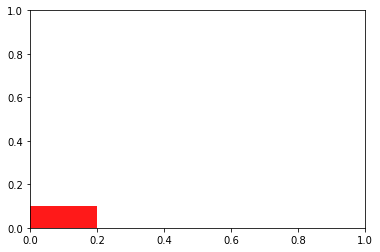

In [223]:
fig, ax = plt.subplots(1)
ax.add_collection(PatchCollection([r], facecolor='r', alpha=0.9))
#ax.add_patch(r)
plt.show()

In [67]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(151)

In [68]:
def draw_array(ax, array, cmap, x0, y0, step = 0.04):
    rectangles = []
    for i, a in enumerate(array):
        if a == '-':
        #if '-' in a:
            color = 'none'
        else:
            color = 'g'#cmap(a*16 % cmap.N)
        rectangles.append(Rectangle((x0 + i * step*2, y0), step*2, step,linewidth=1,
                                    edgecolor='black',
                                    facecolor=color,
                                    alpha = 1))

    for r in rectangles:
        ax.add_patch(r)
    return rectangles #rectangles

In [69]:
def draw_array_triangles(ax, array, cmap, x0, y0, mask = None, step = 0.04):
    rectangles = []
    for i, a in enumerate(array):
        if not mask is None:
            if mask[i] == 0 :
                color = 'none'
            elif mask[i] == 1:
                color = 'g'
            elif mask[i] == 2:
                color = 'y'
        else:
            if a == '-':
                color = 'none'
            else:
                color = cmap(3)
        
        rectangles.append(plt.Polygon([[x0 + i * step*2, y0],
                                       [x0 + (i + 1) * step*2, y0],
                                       [x0 + i * step*2 + step,  y0 + step *1.1]],
                                  #edgecolor='black',
                                  facecolor=color,
                                  alpha = 0.5))

    for r in rectangles:
        ax.add_patch(r)
    return rectangles #rectangles

In [70]:
def draw_allignment(ax, seq, targets, cmap, x0, y0, step=0.04):
    rectangles = draw_array(ax, seq,cmap, x0, y0)
    #plt.show()
    i = 0 
    for i, t in enumerate(targets):
#        if i % 2 ==0:
        mask = []
        for j in range(len(seq)):
            if seq[j] == t[j] and seq[j] == '-':
                mask.append(0)
            elif seq[j] == t[j]:
                mask.append(1)
            else:
                mask.append(2)


        rectangles = draw_array_triangles(ax, t,cmap, x0, y0 - (i+1) * step, mask)
#         else:
#             rectangles = draw_array(ax, t,cmap, y0 - (i+1) * step)
    return y0 - (i+2) * step

In [71]:
test_arrays = [[2,4,5], [3,4,6,5], [0,1,2,3], [0,2,3,4], [3,4,5,6,7,8]]
alignments = ca.water_alignments([1,2,3,4,5], test_arrays)
aligned_seqs = process_alignments(alignments)
s, t =  preprint_multiple_alignment(aligned_seqs)

In [72]:
cmap =get_cmap(7)

In [495]:
# fig, ax = plt.subplots(1, figsize = (15,25))
# ax.set_xlim(0,3)
# ax.set_ylim(0,5)
# y0 = 4.5


# y0 = draw_allignment(ax, s, t, cmap, 0, y0)
# y0 -= 0.05
# plt.show()

In [472]:

        
#     print("++")
#     for x in ca.print_alignments(ca.water_alignments(v, arrs_gr), v):
#         print(x)

In [473]:
answer_ids_fixed[3][0]['first_2']

array([123,  15,   1,  30])

In [474]:
allignments[0]

NameError: name 'allignments' is not defined

In [475]:
process_alignment(alignments[0])

([1, 1, 2, 3, 4, 5], ['-', '-', 2, '-', 4, 5])

In [476]:
alignments

array([[list([1, 2, 3, 4, 5]), list([2, 4, 5]), list([1, 1, 2, 3, 4, 5]),
        list(['-', '-', 2, '-', 4, 5]), 1, 5, 0, 3, 0.8, 1.0, 20.0],
       [list([1, 2, 3, 4, 5]), list([3, 4, 6, 5]),
        list([1, 2, 3, 4, '-', 5]), list(['-', '-', 3, 4, 6, 5]), 2, 5,
        0, 4, 0.6, 1.0, 20.0],
       [list([1, 2, 3, 4, 5]), list([0, 1, 2, 3]),
        list(['-', 1, 2, 3, 4, 5]), list([0, 1, 2, 3, '-', '-']), 0, 3,
        1, 4, 0.6, 0.75, 30.0],
       [list([1, 2, 3, 4, 5]), list([0, 2, 3, 4]), list([1, 2, 3, 4, 5]),
        list([0, 2, 3, 4, '-']), 1, 4, 1, 4, 0.6, 0.75, 30.0],
       [list([1, 2, 3, 4, 5]), list([3, 4, 5, 6, 7, 8]),
        list([1, 2, 3, 4, 5, '-', '-', '-']),
        list(['-', '-', 3, 4, 5, 6, 7, 8]), 2, 5, 0, 3, 0.6, 0.5, 30.0]],
      dtype=object)

In [73]:
def get_cmap(n, name='gray'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(151)

In [508]:
arrs_gr, w = ca.restore_arrays_greedy(grs[3], 25)

In [510]:
answer_ids_fixed[3][0].keys()

dict_keys(['first_2', 'first_3', 'first_5', 'first_7', 'first_8', 'first_21', 'first_27', 'first_65', 'first_9', 'first_12', 'second_2', 'second_5', 'second_21', 'second_65', 'second_3', 'second_7', 'second_8', 'second_27', 'second_9', 'second_12'])

In [86]:
idx = 2
arrs = [x for x in ca.restore_arrays_all(pred_grs[idx])[0] if len(x) > 2]
arrs_gr = [x for x in  ca.restore_arrays_greedy(grs[idx], 10)[0] if len(x) > 2]


In [87]:
idxes = [2, 3, 5, 7, 8, 9, 12, 21, 27, 65]
keys = ca.unwrap_nested([['first_' +  str(x), 'second_' + str(x)] for x in idxes])

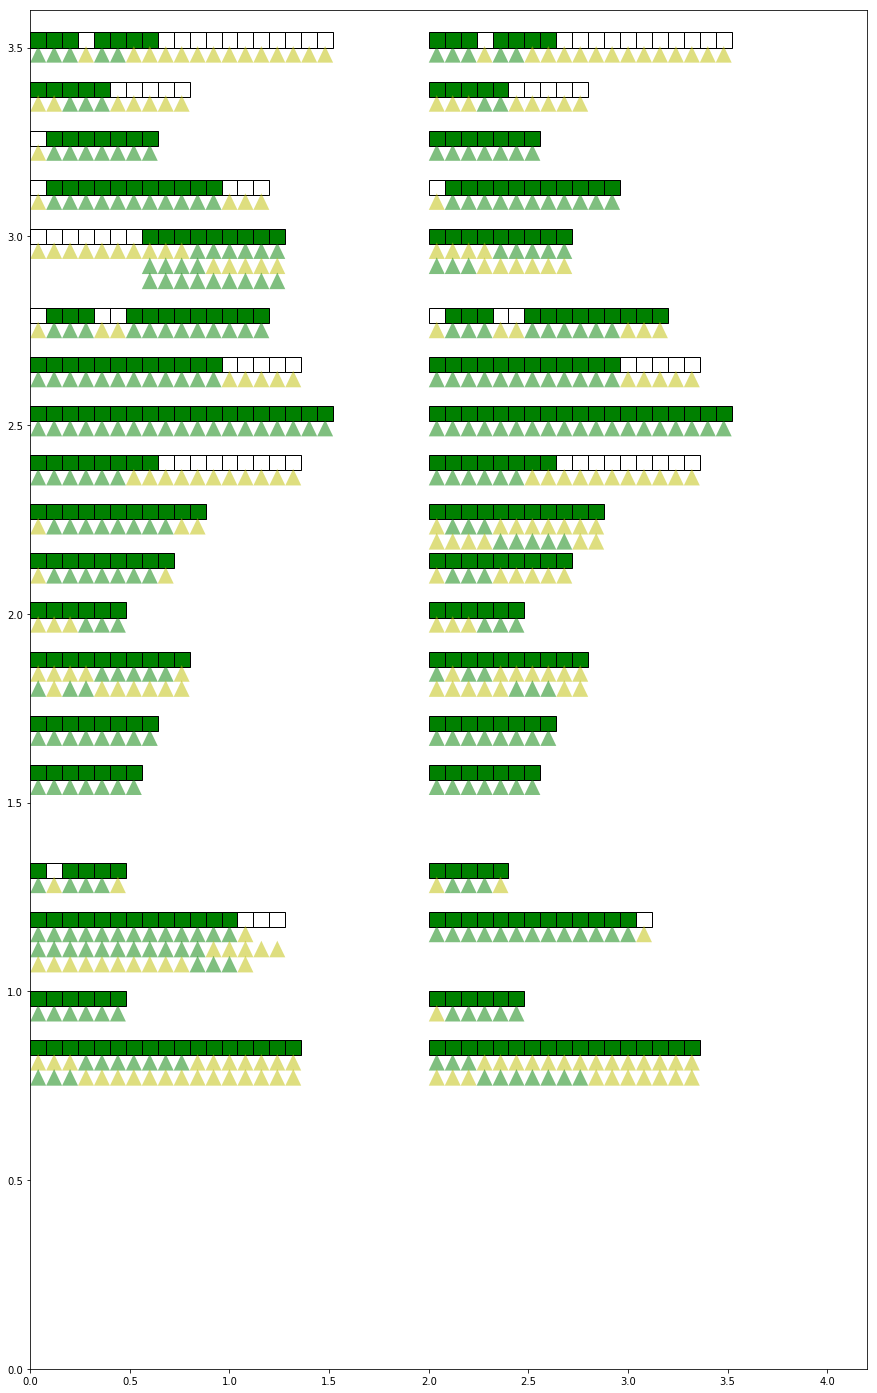

In [88]:
fig, ax = plt.subplots(1, figsize = (15,25))
ax.set_xlim(0,4.2)
ax.set_ylim(0,3.6)
y0 = 3.5

for k, v in answer_ids_fixed[idx][0].items():
    #v= list(answer_ids_fixed[3 ][0]['first_2'])
    alignments = ca.water_alignments(v, arrs)
    aligned_seqs = process_alignments(alignments)
    s, t =  preprint_multiple_alignment(aligned_seqs)   
    y_tmp = draw_allignment(ax, s, t, cmap, 0, y0)
    #y0 -= 0.05
    
       #v= list(answer_ids_fixed[3][0]['first_2'])
    alignments = ca.water_alignments(v, arrs_gr)
    aligned_seqs = process_alignments(alignments)
    s, t =  preprint_multiple_alignment(aligned_seqs)   
    _ = draw_allignment(ax, s, t, cmap, 2, y0)
    y0 = y_tmp
    y0 -= 0.05
plt.show()

ax.set_title("experiment num: " + str(idx))
fig.savefig("../../article/pics/alignment/old_fig_" + str(idx) + ".png", format='png')

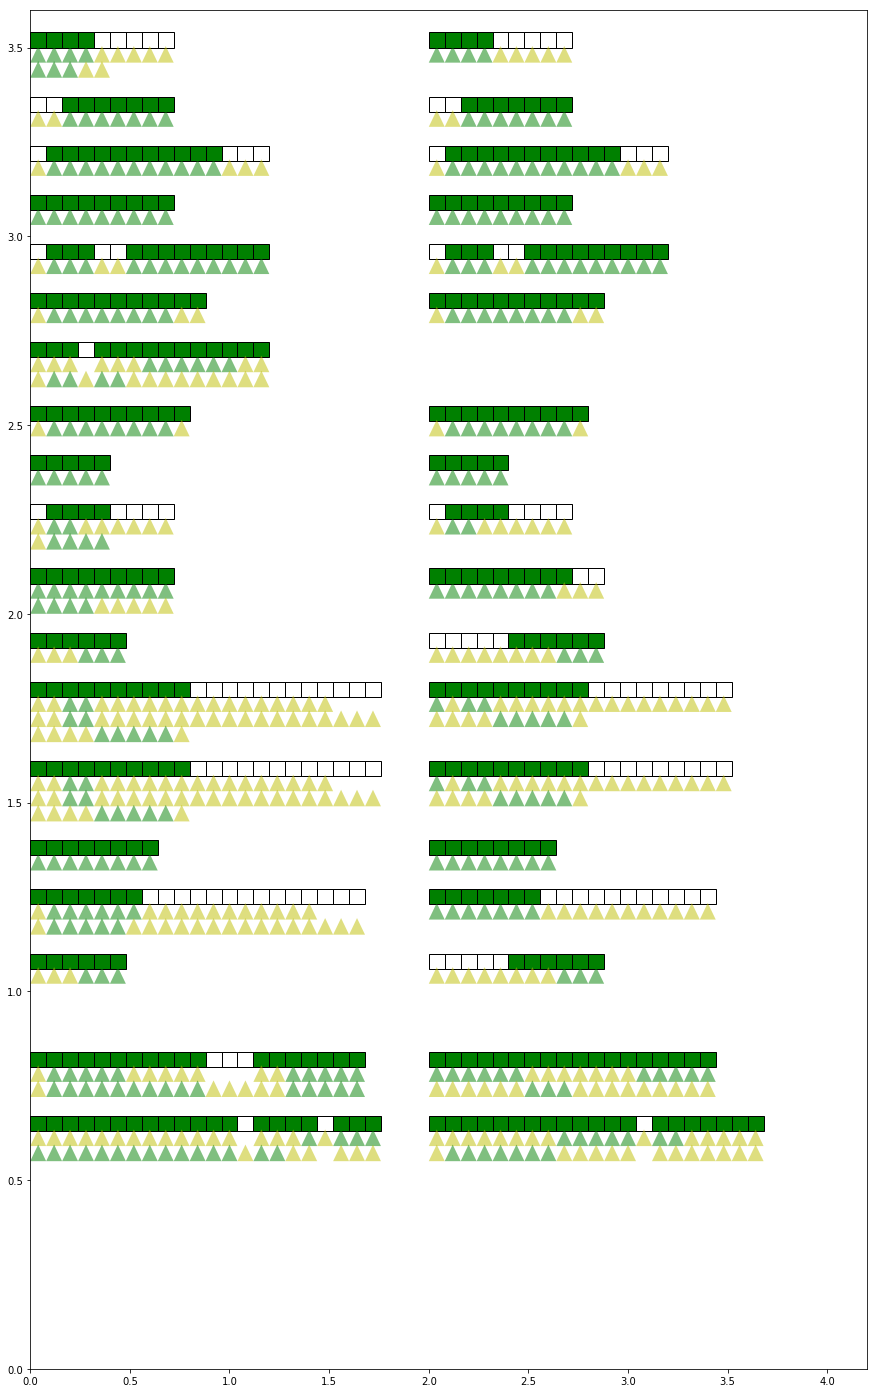

In [546]:
fig, ax = plt.subplots(1, figsize = (15,25))
ax.set_xlim(0,4.2)
ax.set_ylim(0,3.6)
y0 = 3.5

for k,v in answer_ids_fixed[idx][0].items():
    #v= list(answer_ids_fixed[3 ][0]['first_2'])
    alignments = ca.water_alignments(v, arrs)
    aligned_seqs = process_alignments(alignments)
    s, t =  preprint_multiple_alignment(aligned_seqs)   
    y_tmp = draw_allignment(ax, s, t, cmap, 0, y0)
    #y0 -= 0.05
    
       #v= list(answer_ids_fixed[3][0]['first_2'])
    alignments = ca.water_alignments(v, arrs_gr)
    aligned_seqs = process_alignments(alignments)
    s, t =  preprint_multiple_alignment(aligned_seqs)   
    _ = draw_allignment(ax, s, t, cmap, 2, y0)
    y0 = y_tmp
    y0 -= 0.05
plt.show()

In [337]:
def draw_array(rectangles, ax):


SyntaxError: unexpected EOF while parsing (<ipython-input-337-9f7512edcb31>, line 1)

In [335]:
125 * 16 %150

50

In [95]:
res[0].index_to_cluster.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58])

In [100]:
#merged_cluster_to_index = {}
smth = {}

for i in range(grs[0].shape[0])[:-2]:
    cluster = res[0].index_to_cluster[i]
    #print(res[1].cluster_to_index[ca.find_closest(res[1].cluster_to_index, cluster)[1]])
    smth[i] = res[1].cluster_to_index[ca.find_closest(res[1].cluster_to_index, cluster)[1]]

In [117]:
def rearrange_graph(gr, order):
    new_gr = np.zeros((100,100))
    
    for i in range(gr.shape[0] - 4):
        for j in range(gr.shape[1] - 4):
            new_gr[order[i], order[j]] = gr[i,j]
        
    return new_gr

In [82]:
a[1]

({'first_11': [35, 31, 27, 30, 32, 28, 33],
  'first_22': [17, 11, 4, 14, 5, 1, 10, 15],
  'second_11': [23, 22, 21, 26, 34],
  'second_22': [6, 3, 0, 2, 7, 12, 13, 9, 16]},
 {'first_11': [2, 0, 0, 0, 0, 0, 0],
  'first_22': [0, 0, 0, 0, 0, 0, 0, 0],
  'second_11': [0, 0, 0, 0, 0],
  'second_22': [0, 1, 0, 0, 0, 0, 0, 0, 0]})

In [94]:
ca.graph_from_arrays([[1,2], [3,4]])

(array([[0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]]), 0)

In [98]:
grs_answ = [ca.graph_from_arrays([x for x in x[0].values()], 50)[0][:50, :50] for x in a]

In [108]:
grs_restored = [ca.graph_from_arrays([x for x in x[0]], 50)[0][:50, :50] for x in restored]

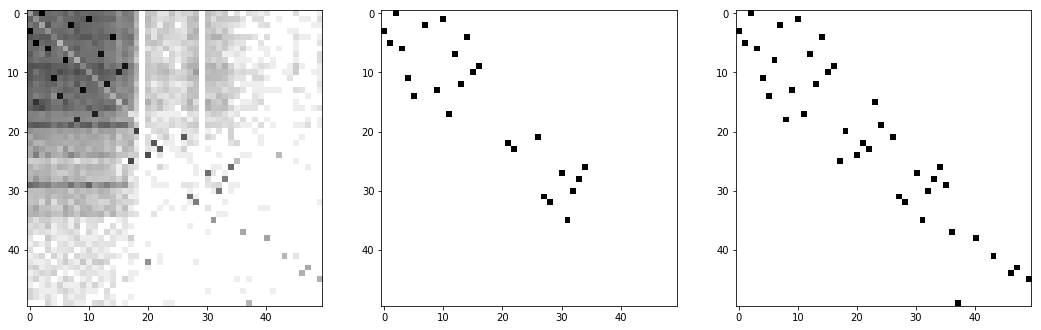

In [112]:
ca.plot_grs(grs[1][:50, :50], grs_answ[1], grs_restored[1], s=18,  log=1)

In [101]:
def calc_noise_ratio(gr0, gr):
    return  gr[gr0 > 0].sum() / gr.sum()

In [114]:
calc_noise_ratio(grs_restored[1], grs[1][:50,:50])

0.7008704988401351

In [119]:
a[0][0]['first_22']

[17, 16, 14, 15, 7, 1, 2, 13]

In [128]:
def calc_array_mean_noise(gr, array):
    total = gr[array][:, array].sum()
    
    total -= np.diag(gr[array][:, array], 1).sum()
    
    return total / (len(array) * (len(array) - 1))

In [129]:
def calc_mean_noise_between(gr, array_1, array_2):
    total = 0
    for i in array_1:
        for j in array_2:
            total += gr[i][j]
            
    return total / (len(array_1) * len(array_2))

In [133]:
idx = 1

In [134]:
print(calc_array_mean_noise(grs[idx], a[idx][0]['first_22']), 
    calc_array_mean_noise(grs[idx], a[idx][0]['second_22']),
      calc_mean_noise_between(grs[idx], a[idx][0]['first_22'], a[idx][0]['second_22']))

344.3392857142857 388.9583333333333 439.31944444444446


In [135]:
print(calc_array_mean_noise(grs[idx], a[idx][0]['first_11']), 
    calc_array_mean_noise(grs[idx], a[idx][0]['second_11']),
      calc_mean_noise_between(grs[idx], a[idx][0]['first_11'], a[idx][0]['second_11']))

0.3333333333333333 1.55 0.14285714285714285


In [122]:
grs[0][a[0][0]['first_22']][:, a[0][0]['first_22']]

array([[   1,  615,    1,    2,    0,    2,    6,    4],
       [   0,    1, 1434,   17,    1,    7,   16,    7],
       [   0,    3,    0, 2476,    5,    7,   18,    4],
       [   0,    3,    3,    1, 2037,   14,   23,   16],
       [   2,   15,    7,   15,    0, 6118,   30,    7],
       [   4,   18,    9,   33,   13,   12, 8116,   23],
       [   3,    6,   10,   17,   15,    6,    6, 3148],
       [   0,    5,    2,    1,    1,   79,    4,    0]])

In [23]:
ca.plot_grs(rearrange_graph(grs[0], smth)[:50, :50], grs[1][:50, :50], log = 1, s = 12)

NameError: name 'rearrange_graph' is not defined

In [131]:
for i in range(80):
    print(res[0].index_to_cluster[i], res[1].index_to_cluster[smth[i]], ed.eval(res[0].index_to_cluster[i], res[1].index_to_cluster[smth[i]]))

GGGTTGACGCCAGCGAACATTGACTCAGA GGGTTGACGCCAGCGAACATTGACTCAGA 0
AATGCATCAGTTGAACACAAAAGTAGCTT AATGCATCAGTTGAACACAAAAGTAGCTT 0
TAAACCACCAGCCAGACCACCAATTACCAC TAAACCACCAGCCAGACCACCAATTACCA 1
GTAACGTGGCGACGACCGGCGATTGATTT GTAACGTGGCGACGACCGGCGATTGATTT 0
TCGAACCTGTTTTTCTTAGTGCGCGCAAC TCGAACCTGTTTTTCTTAGTGCGCGCAAC 0
TACAGTTAAGCGTAAAGTAAGTGATACTGG TACAGTTAAGCGTAAAGTAAGTGATACTG 1
GTTGTTGTAATAAAGCCCCGGAGTTTTAT GTTGTTGTAATAAAGCCCCGGAGTTTTAT 0
TGAGCGTCGGCGGCTCGCTGGATTTGCG TGAGCGTCGGCGGCTCGCTGGATTTGCG 0
GTCGCCGGGTTGATTTTCCATGATGATTT GTCGCCGGGTTGATTTTCCATGATGATTT 0
CGTCCGGATCGGTTTCGAGAATCTCTACG CGTCCGGATCGGTTTCGAGAATCTCTACG 0
GTTTTCATTTGCACGAGCTGCACCATAAGA GTTTTCATTTGCACGAGCTGCACCATAAG 1
GTTATCACCGAGTGCAGTAGCCCGCGCGC GTTATCACCGAGTGCAGTAGCCCGCGCGC 0
GCCCGCCTCGTCGGTGTATTCCGCGAGAT GCCCGCCTCGTCGGTGTATTCCGCGAGAT 0
GCGATGGATCAGGGTATTACACTCGACGGC GCGATGGATCAGGGTATTACACTCGACGG 1
GGAATGATATTTCAATAAATAATTATAAC GGAATGATATTTCAATAAATAATTATAAC 0
TTTTTGTTAATTGCGTTTGCCACGGTTTG TTTTTGTTAATTGCGTTTGCCACGGTTTG 0
AGTGCT

In [85]:
def merge_ordered(s1, threshold = 2):
    s = []
    for el in s1:
        found = ca.find_closest(s, el)
        if found[1] > threshold:
            s.append(el)
    
    return s

In [69]:
gr = np.dot(np.ones((3,1)), np.arange(3).reshape(1,3))

In [70]:
merge_ordered(res[0].spacers.union(res[1].spacers))

StopIteration: 

In [32]:
a[0]

{'first_11': [44, 20, 19, 21, 27, 24, 25],
 'first_2': [47, 50, 13, 9, 30],
 'first_3': [9, 20, 9, 19, 9, 47, 42],
 'first_5': [7, 0, 20, 28, 38, 13, 9, 35, 34, 7, 13],
 'first_7': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19],
 'first_8': [7, 0, 20, 13, 9, 35, 34, 7, 13, 1, 51, 7],
 'first_14': [17, 16, 14, 15, 7, 1, 0, 41, 2, 26, 26, 24],
 'first_15': [44, 20, 19, 4, 21, 27, 0, 6, 8, 29, 24, 25],
 'first_22': [17, 16, 14, 15, 7, 1, 2, 13],
 'first_21': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19, 15],
 'second_2': [32, 35, 37, 3, 11, 1, 13, 2, 22],
 'second_5': [9, 18, 11, 2, 57, 15],
 'second_21': [29, 1, 22, 26, 12, 15, 6, 3, 18, 18],
 'second_3': [44, 0, 0, 1, 4, 1, 20, 36],
 'second_7': [29, 22, 26, 8, 45, 22, 0],
 'second_8': [58, 18, 40, 28, 14, 3],
 'second_11': [32, 28, 31, 34, 43],
 'second_14': [32, 18, 4, 18, 16, 5, 24, 13, 30, 7, 33, 7, 32],
 'second_15': [32, 18, 28, 31, 34, 12],
 'second_22': [11, 8, 3, 4, 9, 6, 0, 5, 10]}

In [24]:
restored = [ca.restore_arrays(x) for x in grs]

In [5]:
rep = 'CGGTTTATCCCCGCTGGCGCGGGGAACAC'
s = rep.join(answer_sensivity['first_11'])

In [7]:
s[:100]

'AAAACCAAACTTCTCCATAAATTCCATAGCCGCGGTTTATCCCCGCTGGCGCGGGGAACACGAGTCTATCAGCGACACTACCGGCAATAGCGACGGTTTA'

In [74]:
struct = '....(((....................((((((((((...((((((....))))))................................\
.............((((((....))))))........((((((..........))))))..))))))))))..(((((((....)))))))\
............................................((((((....))))))....((((........(((((((((.....(((\
(((((((.......)))))))))).))))))))).......))))...........................(((((((....)))))))....\
..............................)))'

In [69]:
import regex as re

In [76]:
for split in [x.span() for x in re.finditer(rep, s)]: 
    print(struct[split[0]:split[1]])

(((((...((((((....)))))).....
........((((((....)))))).....
)))))..(((((((....)))))))....
........((((((....))))))....(
(((.......)))))))))).))))))))
.......(((((((....)))))))....


In [79]:
get_weights(grs[0], [a[0][0]['first_11']])

[[21, 150, 163, 57, 70, 76]]

In [30]:
def search_ays_in_b(a, b, gr):
    res = []
    for a_name, a_array in a.items():
        matched_parts, b_name, positions = ca.search_best_alignment(
            a_array,
            b)

        res.append(ca.Match(a_name,
             b_name,
             len(matched_parts[0]) / len(a_array),
             len(matched_parts[1]) / len(b[b_name]),
             a_array,
             b[b_name],
             get_weights(gr, [a_array]),
             get_weights(gr, [b[b_name]])))
        
        res[-1].print()
    
    return res

In [49]:
answer_sensivity

{'first_11': ['AAAACCAAACTTCTCCATAAATTCCATAGCCG',
  'GAGTCTATCAGCGACACTACCGGCAATAGCGA',
  'CTATAGCGCCACGTTCCGAGCGCTGCGAGCTG',
  'CTAATGAGTCAGTTTGAACAGATCCCCGACAA',
  'GGCTTTAAAATTGTGTTCCCGTCTGGCGCTGG',
  'GCATCCATGCCGACGCCTTTACGTGTGCGGGG',
  'GCGCGAATTTGTGCGCATGGGGCGCATTTTTGG'],
 'first_2': ['TCTAAGTGATATCCATCATCGCATCCAGTGCGCC',
  'TCTTACTGCTTGGTATGCGGAATCACACCCTGAA',
  'ACTGAAGCATCAAACATTTGGTGGACCAAACGGA',
  'ACTGTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'ACGGATCTGCCAGCGCCTCTGCGGGGCGGTAAAC'],
 'first_3': ['GTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'GATCTGCCAGCGCCTCTGCGGGGCGGTAAAC',
  'ACGCCAGCCACCTGCTTCGCCAGCCGTTCGG',
  'CACGGTAGCGCCACTGCGCGTCGGTGACGGG',
  'ACGAACAGGGATTTGTCGGCAGTTTCTTTAC',
  'TAATTCGCAAATCAATATATATTTTGTCCGT',
  'ATTGCGGATGCTCCCGGAATTGCGCGGGCAA'],
 'first_5': ['CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC',
  'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG',
  'GTAGTCCATCATTCCACCTATGTCTGAACTCC',
  'CCGGGGGATAATGTTTACGGTCATGCGCCCCC',
  'ATCGTCCATATTAACAATCGTGGTGAGTTCAA',
  'ACTATGGCCCCGGCAAAAAACGCGCTGGTGGG'

In [57]:
a[0]

{'first_11': [44, 20, 19, 21, 27, 24, 25],
 'first_2': [47, 50, 13, 9, 30],
 'first_3': [9, 20, 9, 19, 9, 47, 42],
 'first_5': [7, 0, 20, 28, 38, 13, 9, 35, 34, 7, 13],
 'first_7': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19],
 'first_8': [7, 0, 20, 13, 9, 35, 34, 7, 13, 1, 51, 7],
 'first_14': [17, 16, 14, 15, 7, 1, 0, 41, 2, 26, 26, 24],
 'first_15': [44, 20, 19, 4, 21, 27, 0, 6, 8, 29, 24, 25],
 'first_22': [17, 16, 14, 15, 7, 1, 2, 13],
 'first_21': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19, 15],
 'second_2': [32, 35, 37, 3, 11, 1, 13, 2, 22],
 'second_5': [9, 18, 11, 2, 57, 15],
 'second_21': [29, 1, 22, 26, 12, 15, 6, 3, 18, 18],
 'second_3': [44, 0, 0, 1, 4, 1, 20, 36],
 'second_7': [29, 22, 26, 8, 45, 22, 0],
 'second_8': [58, 18, 40, 28, 14, 3],
 'second_11': [32, 28, 31, 34, 43],
 'second_14': [32, 18, 4, 18, 16, 5, 24, 13, 30, 7, 33, 7, 32],
 'second_15': [32, 18, 28, 31, 34, 12],
 'second_22': [11, 8, 3, 4, 9, 6, 0, 5, 10]}

In [61]:
a[1][1]

{'first_11': [2, 0, 0, 0, 0, 0, 0],
 'first_2': [2, 13, 5, 5, 5],
 'first_3': [4, 4, 12, 12, 13, 13, 10],
 'first_5': [13, 13, 14, 14, 12, 15, 14, 14, 13, 3, 3],
 'first_7': [2, 3, 3, 3, 3, 3, 2, 3, 2, 2],
 'first_8': [13, 13, 14, 15, 14, 14, 13, 3, 3, 14, 3, 13],
 'first_14': [0, 0, 0, 0, 0, 0, 14, 13, 0, 13, 13, 15],
 'first_15': [2, 0, 0, 14, 0, 0, 13, 13, 14, 13, 0, 1],
 'first_22': [0, 0, 0, 0, 0, 0, 0, 0],
 'first_21': [2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 11],
 'second_2': [0, 3, 3, 3, 13, 13, 3, 12, 14],
 'second_5': [3, 4, 4, 4, 5, 11],
 'second_21': [2, 3, 1, 1, 1, 3, 4, 4, 3, 3],
 'second_3': [13, 13, 12, 15, 12, 14, 13, 13],
 'second_7': [1, 0, 0, 12, 14, 14, 14],
 'second_8': [15, 15, 15, 13, 15, 14],
 'second_11': [0, 0, 0, 0, 0],
 'second_14': [0, 3, 12, 14, 3, 3, 12, 3, 3, 3, 14, 3, 4],
 'second_15': [0, 14, 0, 0, 0, 13],
 'second_22': [0, 1, 0, 0, 0, 0, 0, 0, 0]}

In [60]:
search_ays_in_b(a[1][0], dict(zip(np.arange(len(restored[1][0])), restored[1][0])), grs[1])

searched name: first_11
 found name: 2
 searched_overlap: 1.0
 found_overlap: 1.0
 arrs (search, found): 
[35, 31, 27, 30, 32, 28, 33]
[29, 35, 31, 27, 30, 32, 28, 33]
 weights (search, found):
[[61, 306, 341, 213, 193, 190]]
[[1, 61, 306, 341, 213, 193, 190]]
 _____________________

searched name: first_2
 found name: 14
 searched_overlap: 0.8
 found_overlap: 1.0
 arrs (search, found): 
[25, 64, 85, 78, 94]
[85, 78, 94]
 weights (search, found):
[[0, 0, 2, 1]]
[[2, 1]]
 _____________________

searched name: first_3
 found name: 14
 searched_overlap: 0.2857142857142857
 found_overlap: 1.0
 arrs (search, found): 
[78, 94, 97, 27, 7, 71, 29]
[85, 78, 94]
 weights (search, found):
[[1, 0, 0, 12, 0, 0]]
[[2, 1]]
 _____________________

searched name: first_5
 found name: 1
 searched_overlap: 0.2727272727272727
 found_overlap: 0.21428571428571427
 arrs (search, found): 
[5, 13, 31, 22, 40, 15, 7, 37, 26, 92, 98]
[25, 17, 11, 4, 14, 5, 1, 10, 15, 23, 22, 21, 26, 34]
 weights (search, found):

In [35]:
for key in a[0].keys():
    print(key, a[0][key])
    print(search_ays_in_b(a[0][key], dict(zip(np.arange(len(restored[0])), restored[0])), grs[0]))
    print("_____________________________________")

first_11 [44, 20, 19, 21, 27, 24, 25]


AttributeError: 'list' object has no attribute 'items'

In [29]:
a[0]

{'first_11': [44, 20, 19, 21, 27, 24, 25],
 'first_2': [47, 50, 13, 9, 30],
 'first_3': [9, 20, 9, 19, 9, 47, 42],
 'first_5': [7, 0, 20, 28, 38, 13, 9, 35, 34, 7, 13],
 'first_7': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19],
 'first_8': [7, 0, 20, 13, 9, 35, 34, 7, 13, 1, 51, 7],
 'first_14': [17, 16, 14, 15, 7, 1, 0, 41, 2, 26, 26, 24],
 'first_15': [44, 20, 19, 4, 21, 27, 0, 6, 8, 29, 24, 25],
 'first_22': [17, 16, 14, 15, 7, 1, 2, 13],
 'first_21': [47, 34, 18, 5, 11, 32, 57, 0, 0, 19, 15],
 'second_2': [32, 35, 37, 3, 11, 1, 13, 2, 22],
 'second_5': [9, 18, 11, 2, 57, 15],
 'second_21': [29, 1, 22, 26, 12, 15, 6, 3, 18, 18],
 'second_3': [44, 0, 0, 1, 4, 1, 20, 36],
 'second_7': [29, 22, 26, 8, 45, 22, 0],
 'second_8': [58, 18, 40, 28, 14, 3],
 'second_11': [32, 28, 31, 34, 43],
 'second_14': [32, 18, 4, 18, 16, 5, 24, 13, 30, 7, 33, 7, 32],
 'second_15': [32, 18, 28, 31, 34, 12],
 'second_22': [11, 8, 3, 4, 9, 6, 0, 5, 10]}

In [25]:
restored[0][0]

[[18, 29, 22, 26, 12, 11, 8, 3, 4, 9, 6, 0, 5, 10],
 [47, 17, 16, 14, 15, 7, 1, 2, 13],
 [44, 20, 19, 21, 27, 24, 25],
 [32, 28, 31, 34, 43],
 [54, 46, 35, 36, 45, 48, 40, 33, 38, 37, 41, 39],
 [51, 55],
 [50, 52, 56]]

In [46]:
answ_gr = ca.graph_from_arrays([x for x in a.values()], 500)[0]

In [47]:
embs = make_vertexes_embs(gr)

In [48]:
graph_restored = gb.predict(embs[:, 1:]).reshape(gr.shape)

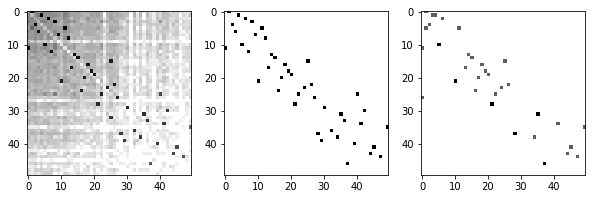

In [49]:
c1, c2, = 0, 50

ca.plot_grs(gr[c1:c2, c1:c2].astype(int),
            graph_restored[c1:c2, c1:c2],
            answ_gr[c1:c2, c1:c2],
            
            log = 1,
            s = 10)

In [50]:
restored_arrays = [x for x in restore_all(graph_restored) if len(x) > 1]
weights = get_weights(gr, restored_arrays)

In [51]:
for ra,wa  in zip(restored_arrays, weights):
    print(ra)
    print(wa)
    print("--------------------------------------------")

[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 22, 26, 27]
[5491, 5550, 7881, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 5456, 6225, 4275]
--------------------------------------------
[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 22, 171]
[5491, 5550, 7881, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 5456, 17]
--------------------------------------------
[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 40, 39, 29, 30, 42]
[5491, 5550, 7881, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 1200, 1845, 1732, 3795, 1857]
--------------------------------------------
[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 40, 39, 29, 30, 196]
[5491, 5550, 7881, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 1200, 1845, 1732, 3795, 5]
--------------------------------------------
[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 159]
[5491, 5550, 7881, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 37]
--------------------------------------------
[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 188]
[5491, 5550, 7881, 7389, 7254

In [52]:
restored_arrays_filtered = [[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 22, 26, 27],
                            [40, 39, 29, 30, 42],
                            [23, 94, 96, 101, 110, 130],
                            [23, 145, 149, 148, 153, 152, 177, 169, 200],
                            [31, 35, 49, 56, 50, 48, 58, 73, 76],
                            [80, 165, 174, 191],
                            [33, 36, 32],
                            [38, 34, 41, 45],
                            [46, 37, 28, 21, 10, 5, 11, 0, 1, 4, 2, 6, 3, 8, 12, 7, 9],
                            [70, 90, 69, 71, 68, 78, 89, 75, 83, 98],
                            [70, 118, 157, 150, 146, 166],
                            [85, 109, 112, 143, 144, 141, 139, 155, 170, 180],
                            [105, 66, 57, 43, 44, 47, 72],
                            [123, 99, 104, 106, 100, 108, 114, 124],
                            [127, 79, 67, 77, 81, 64, 55, 62, 60, 54, 59, 51, 53, 61, 65, 63, 74, 87, 92],
                            [197, 163, 95, 93, 82, 84, 91, 115, 117]]



In [53]:
restored_gr_filtered = ca.graph_from_arrays(restored_arrays_filtered, 500)[0]

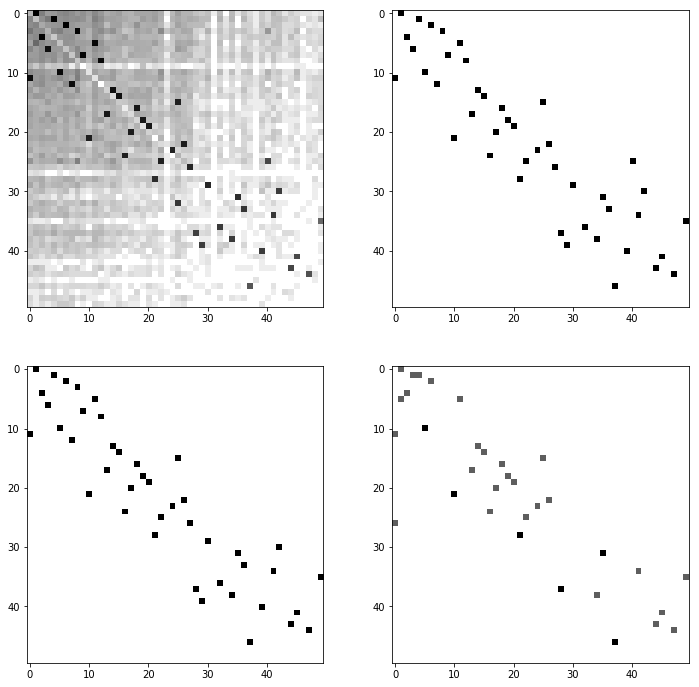

In [54]:
c1, c2, = 0, 50

ca.plot_grs(gr[c1:c2, c1:c2],
            graph_restored[c1:c2, c1:c2],
            restored_gr_filtered[c1:c2, c1:c2],
            answ_gr[c1:c2, c1:c2],
            
            log = 1,
            s = 12, 
            subplots_form = (2,2))

In [111]:
restored_gr_filtered[66,88]

0

In [55]:
restored_arrays_filtered_dict = dict(zip(np.arange(len(restored_arrays_filtered)), restored_arrays_filtered))

In [71]:
res.corrector.index_to_cluster[59]

'GCATCCATGCCGACGCCTTTACGTGTGCG'

In [72]:
res.corrector.index_to_cluster[55]

'GAGAGTGCTGACAGGTGTCTCGATTACCT'

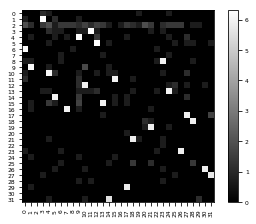

In [78]:
ca.plot_gr(gr[50:82, 50:82], all_ticks=1, log =1)

In [85]:
print(get_weights(gr, [[86, 31, 35, 50, 48, 58, 73, 76, 80, 165, 174, 191], [31, 35, 49, 56, 50, 48, 58, 73, 76]]))


[[39, 3174, 1, 585, 642, 389, 360, 346, 7, 13, 6], [3174, 349, 601, 490, 585, 642, 389, 360]]


In [94]:
sorted([x.name_2 for x in comp_log])

[0, 2, 2, 3, 4, 4, 7, 8, 8, 8, 9, 10, 11, 11, 12, 13, 14, 14, 15, 15]

In [92]:
comp_log = search_ays_in_b(a, restored_arrays_filtered_dict, gr)

searched name: first_11
 found name: 14
 searched_overlap: 0.7142857142857143
 found_overlap: 0.3157894736842105
 arrs (search, found): 
[127, 79, 67, 81, 64, 59, 51]
[127, 79, 67, 77, 81, 64, 55, 62, 60, 54, 59, 51, 53, 61, 65, 63, 74, 87, 92]
 weights (search, found):
[[40, 335, 4, 254, 3, 485]]
[[40, 335, 363, 313, 254, 419, 534, 411, 463, 524, 485, 551, 525, 410, 388, 404, 295, 222]]
 _____________________

searched name: first_2
 found name: 15
 searched_overlap: 1.0
 found_overlap: 0.4444444444444444
 arrs (search, found): 
[85, 197, 163, 95, 93]
[197, 163, 95, 93, 82, 84, 91, 115, 117]
 weights (search, found):
[[0, 6, 16, 194]]
[[6, 16, 194, 192, 250, 256, 74, 50]]
 _____________________

searched name: first_3
 found name: 15
 searched_overlap: 1.0
 found_overlap: 0.8888888888888888
 arrs (search, found): 
[95, 93, 82, 84, 91, 115, 117]
[197, 163, 95, 93, 82, 84, 91, 115, 117]
 weights (search, found):
[[194, 192, 250, 256, 74, 50]]
[[6, 16, 194, 192, 250, 256, 74, 50]]
 _____

In [101]:
d

{'first_11': [3, 1, 0, 1, 0, 0, 1],
 'first_2': [2, 5, 4, 4, 3],
 'first_3': [3, 2, 2, 2, 2, 2, 3],
 'first_5': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'first_7': [1, 2, 1, 2, 2, 2, 2, 2, 2, 2],
 'first_8': [1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2],
 'first_14': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'first_15': [3, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 2],
 'first_22': [1, 0, 0, 0, 0, 0, 0, 0],
 'first_21': [1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 12],
 'second_2': [0, 2, 2, 2, 2, 2, 2, 2, 2],
 'second_5': [3, 1, 2, 1, 2, 2],
 'second_21': [3, 3, 2, 2, 3, 2, 3, 3, 3, 3],
 'second_3': [3, 2, 1, 1, 1, 1, 1, 2],
 'second_7': [2, 1, 1, 0, 0, 0, 0],
 'second_8': [15, 13, 13, 13, 15, 14],
 'second_11': [0, 1, 1, 1, 13],
 'second_14': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'second_15': [0, 1, 1, 1, 1, 2],
 'second_22': [1, 2, 0, 0, 1, 1, 0, 1, 1]}

In [110]:
','.join([res.corrector.index_to_cluster[x] for x in [46, 37, 28, 21, 10, 5, 11, 0, 1, 4, 2, 6, 3, 8, 12, 7, 9]])

'ACATGAATGTCGGTTCAGACCGTGTTTTT,AGTGCTGGACCATTTCAAATTCACAATAG,GGAATGATATTTCAATAAATAATTATAAC,TTTTTGTTAATTGCGTTTGCCACGGTTTG,TGAGCGTCGGCGGCTCGCTGGATTTGCG,AATGCATCAGTTGAACACAAAAGTAGCTT,TTTTGCTGACACCGGCAATACTGAACGGC,ACGGATTGCGGTATATGCAGTGTCCAGAT,TAAACCACCAGCCAGACCACCAATTACCA,GGGGATAACGGTTATCCACTGGCCGCCGA,TGTAATAGCCTGATCTCTGATCTCCCTCG,CTGTCCCAGGCCGAGGCTGTATTTCAATCC,GCGATGGATCAGGGTATTACACTCGACGG,GCTGCGGGTCAATCAACTGGAGTGCAAATC,GTCGCGCGCCGACGGAATAAACCGAATAA,TCGTCAGGGCACAATAACTGAGGTTCGCA,AGCAACGCGTAAACCAGATCGCCGATCGTG'

In [57]:
for key in a.keys():
    print(key, a[key])
    print(search_ays_in_b(a[key], restored_arrays_filtered_dict))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]


AttributeError: module 'crispr_assembler' has no attribute 'search_ays_in_b'

In [58]:
for key in a.keys():
    print(key, a[key])
    print(ca.search_best_alignment(a[key], restored))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]


NameError: name 'restored' is not defined

In [36]:
for key in a.keys():
    print(key, a[key])
    print(ca.search_best_alignment(a[key], restored))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]
(([127, 79, 67, 81, 64], [127, 79, 67, 77, 81, 64]), 47, (0, 5, 0, 6))
_____________________________________
first_2 [85, 197, 163, 95, 93]
(([85, 197, 163, 95, 93], [197, 163, 95, 93]), 48, (0, 5, 0, 4))
_____________________________________
first_3 [95, 93, 82, 84, 91, 115, 117]
(([95, 93, 82, 84, 91, 115, 117], [163, 95, 93, 82, 84, 91, 115, 117]), 48, (0, 7, 1, 9))
_____________________________________
first_5 [86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80]
(([86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80], [31, 35, 49, 56, 50, 48, 58, 73, 76, 80]), 18, (0, 11, 0, 10))
_____________________________________
first_7 [85, 109, 112, 143, 144, 141, 139, 155, 170, 180]
(([85, 109, 112, 143, 144, 141, 139, 155, 170, 180], [85, 109, 112, 143, 144, 141, 139, 155, 170, 180]), 41, (0, 10, 0, 10))
_____________________________________
first_8 [86, 31, 35, 50, 48, 58, 73, 76, 80, 165, 174, 191]
(([35, 50, 48, 58, 73, 76, 80, 165, 174, 191], [56, 50, 48, 58, 73, 

In [113]:
ca.dict_to_csv(ca.revert_dict(res.cluster_to_index), "./sensitivity_idx_to_sp")

In [121]:
with open("./sensitivity_restored", 'w') as f:
    for k,v in restored_arrays_filtered_dict.items():
        f.write(str(k))
        f.write("\n")
        f.write("\t".join([ca.revert_dict(res.cluster_to_index)[x] for x in v]))
        f.write("\n")

In [125]:
with open("./sensitivity_answer", 'w') as f:
    for k,v in answer_sensivity.items():
        f.write(str(k))
        f.write("\n")
        f.write("\t".join(v))
        f.write("\n")

In [124]:
answer_sensivity

{'first_11': ['AAAACCAAACTTCTCCATAAATTCCATAGCCG',
  'GAGTCTATCAGCGACACTACCGGCAATAGCGA',
  'CTATAGCGCCACGTTCCGAGCGCTGCGAGCTG',
  'CTAATGAGTCAGTTTGAACAGATCCCCGACAA',
  'GGCTTTAAAATTGTGTTCCCGTCTGGCGCTGG',
  'GCATCCATGCCGACGCCTTTACGTGTGCGGGG',
  'GCGCGAATTTGTGCGCATGGGGCGCATTTTTGG'],
 'first_2': ['TCTAAGTGATATCCATCATCGCATCCAGTGCGCC',
  'TCTTACTGCTTGGTATGCGGAATCACACCCTGAA',
  'ACTGAAGCATCAAACATTTGGTGGACCAAACGGA',
  'ACTGTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'ACGGATCTGCCAGCGCCTCTGCGGGGCGGTAAAC'],
 'first_3': ['GTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'GATCTGCCAGCGCCTCTGCGGGGCGGTAAAC',
  'ACGCCAGCCACCTGCTTCGCCAGCCGTTCGG',
  'CACGGTAGCGCCACTGCGCGTCGGTGACGGG',
  'ACGAACAGGGATTTGTCGGCAGTTTCTTTAC',
  'TAATTCGCAAATCAATATATATTTTGTCCGT',
  'ATTGCGGATGCTCCCGGAATTGCGCGGGCAA'],
 'first_5': ['CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC',
  'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG',
  'GTAGTCCATCATTCCACCTATGTCTGAACTCC',
  'CCGGGGGATAATGTTTACGGTCATGCGCCCCC',
  'ATCGTCCATATTAACAATCGTGGTGAGTTCAA',
  'ACTATGGCCCCGGCAAAAAACGCGCTGGTGGG'

In [114]:
res.dump("./sensitivity_res")

In [ ]:
ca.Comparator(restored, a, sp_to_id)

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

## True arrays

In [26]:
gr = res[0].graph_from_pairs()[0]

first_11


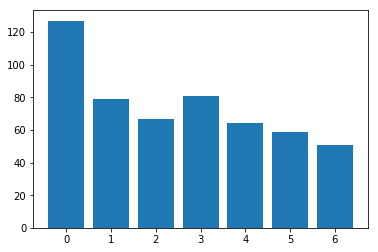

first_2


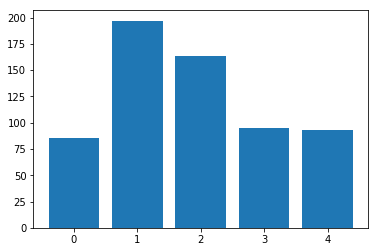

first_3


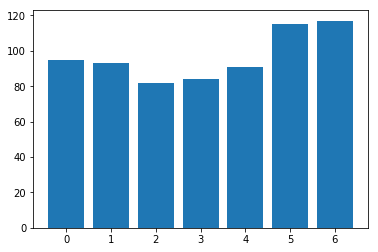

first_5


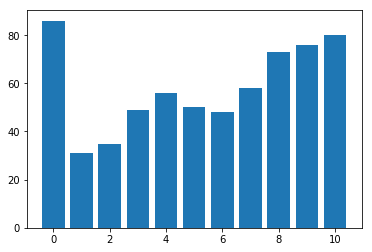

first_7


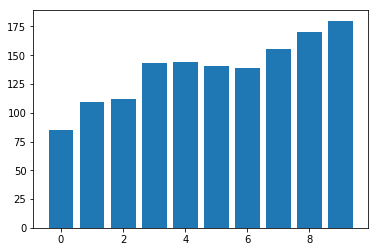

first_8


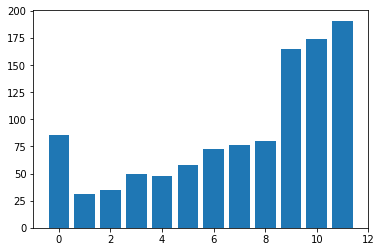

first_14


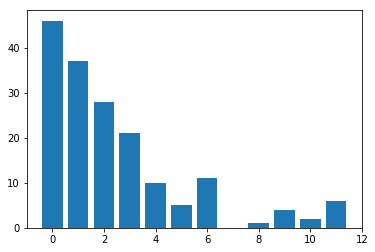

first_15


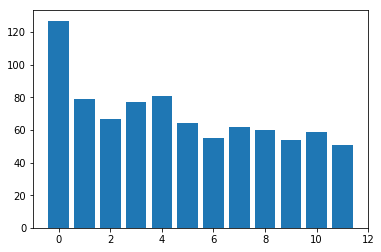

first_22


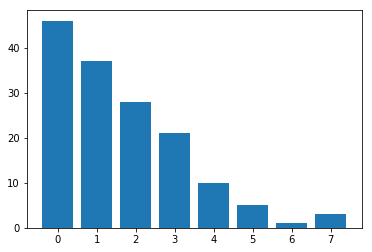

first_21


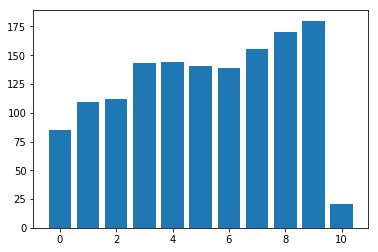

second_2


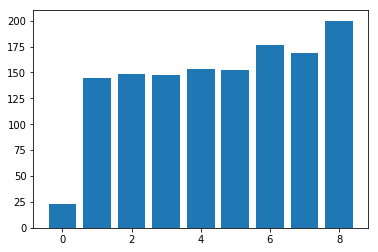

second_5


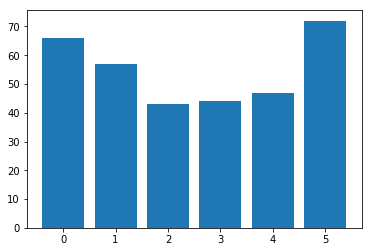

second_21


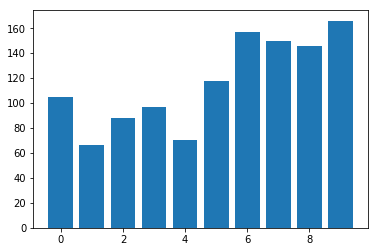

second_3


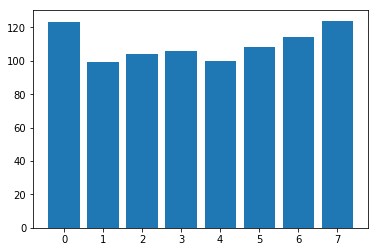

second_7


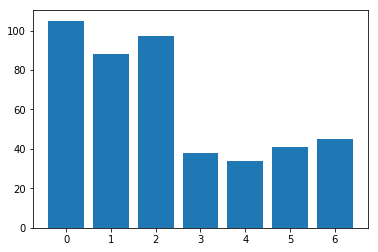

second_8


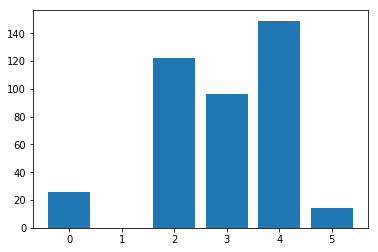

second_11


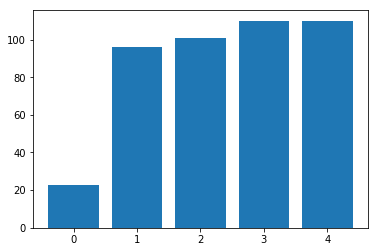

second_14


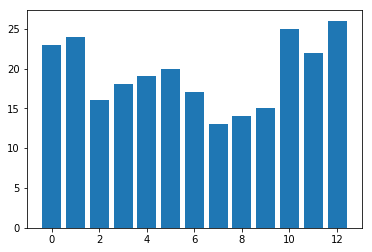

second_15


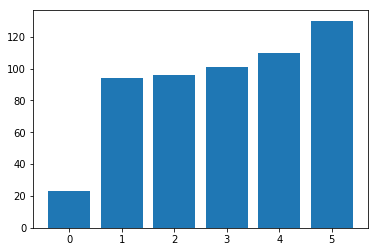

second_22


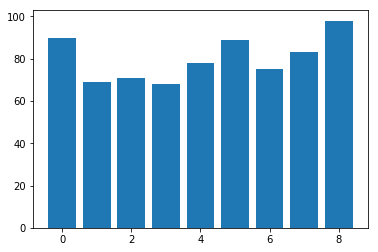

In [18]:
for key, arr in a.items():
    print(key)
    plt.bar(np.arange(len(arr)), arr)
    plt.show()

first_11


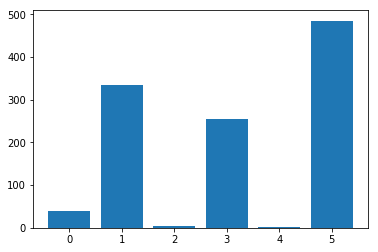

first_2


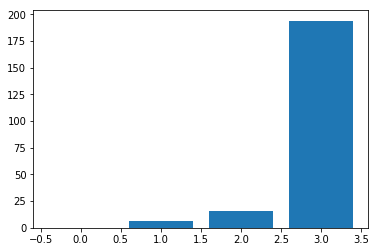

first_3


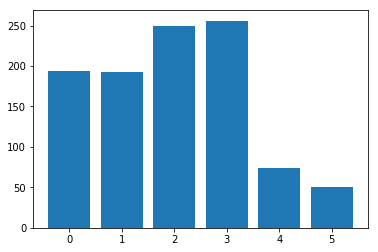

first_5


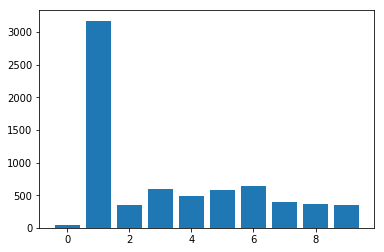

first_7


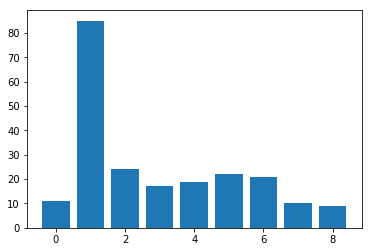

first_8


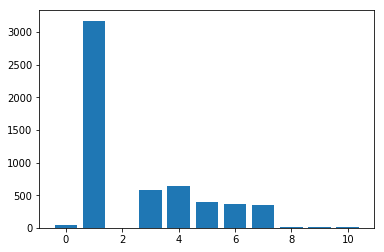

first_14


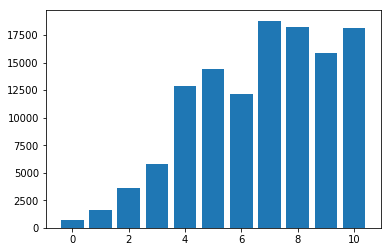

first_15


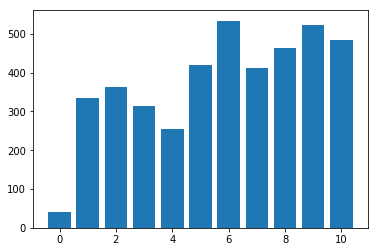

first_22


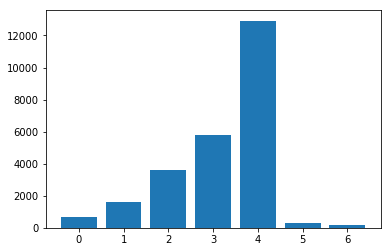

first_21


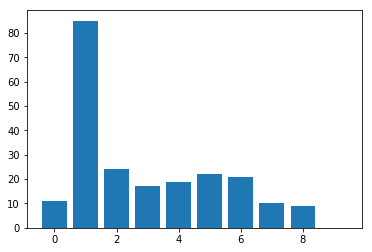

second_2


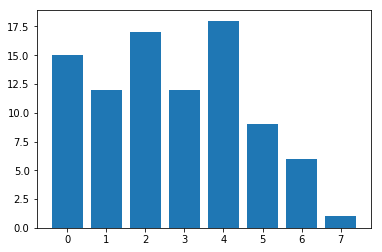

second_5


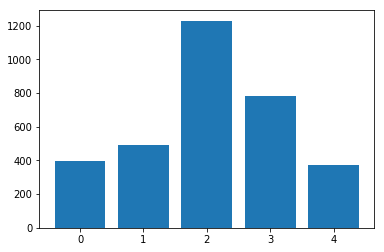

second_21


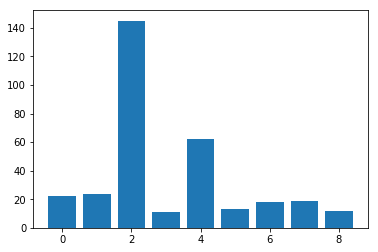

second_3


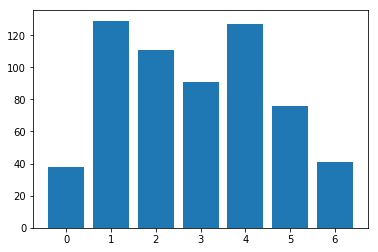

second_7


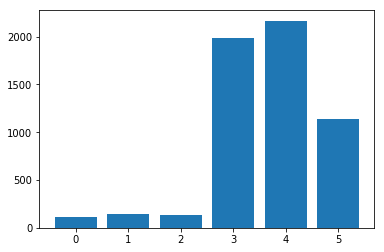

second_8


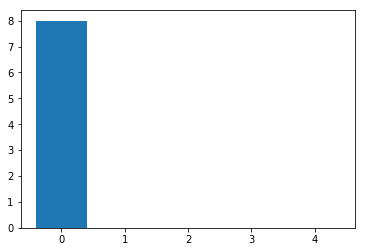

second_11


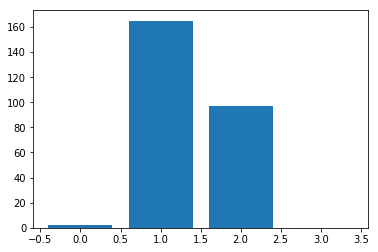

second_14


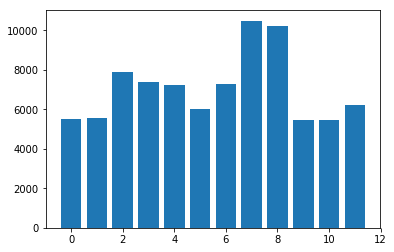

second_15


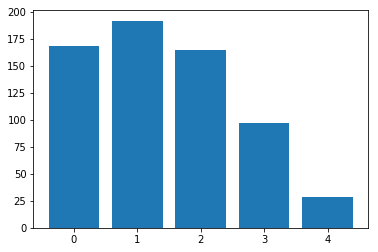

second_22


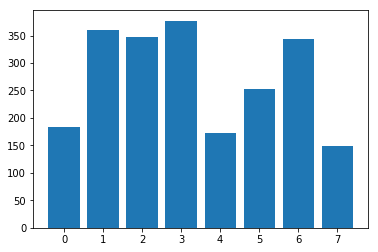

In [27]:
for key, arr in a.items():
    print(key)
    w = []
    for x,y in zip(arr, arr[1:]):
        w.append(gr[x, y])
        
    plt.bar(np.arange(len(w)), w)
    plt.show()

In [22]:
arr

[127, 79, 67, 81, 64, 59, 51]

In [25]:
strain 14 = 2 ng/ul
strain 7 = 1 ng/ul
strain 3 = 0.5 ng/ul
strain 5 = 0.25 ng/ul
strain 22 = 0.125 ng/ul
strain 15 = 0.0625 ng/ul
strain 21 = 0.031 ng/ul
strain 2 = 0.015 ng/ul
strain 8 = 0.007 ng/ul
strain 11 = 0.003 ng/ul

IndexError: tuple index out of range

In [30]:
for key, arr in a.items():
    print(key, np.median(arr))# np.median(sorted(arr)[1:-1]))
#     w = []
#     for x,y in zip(arr, arr[1:]):
#         w.append(gr[x, y])
        
#     plt.bar(np.arange(len(w)), w)
#     plt.show()

first_11 67.0
first_2 95.0
first_3 93.0
first_5 56.0
first_7 142.0
first_8 74.5
first_14 8.0
first_15 63.0
first_22 15.5
first_21 141.0
second_2 152.0
second_5 52.0
second_21 111.5
second_3 107.0
second_7 45.0
second_8 61.0
second_11 101.0
second_14 19.0
second_15 98.5
second_22 78.0


In [531]:
ca.rc('CCTTATAGGTACGGTTCAAAGGTTTCAAACCCTTATAGGTACGGTTCAAAGCCGGGGACTCCGCACTTGAGGTCATGGCAGACATCGGGTTTCAAACCCTCATAGGTACGGGTCAAAGCCTCCTTCTGGAAAGCGTTTGATTGCGGAGCATACCAGGTTTCAAACCCTTATAGGTACGGTTCAAAGGATGGAGGTGTCGCCATGGGGAACGAGGTAGTTCAGGTTTCAAGCCCTCATAGGTACGGTTCAAA', r = 1)

'TTTGAACCGTACCTATGAGGGCTTGAAACCTGAACTACCTCGTTCCCCATGGCGACACCTCCATCCTTTGAACCGTACCTATAAGGGTTTGAAACCTGGTATGCTCCGCAATCAAACGCTTTCCAGAAGGAGGCTTTGACCCGTACCTATGAGGGTTTGAAACCCGATGTCTGCCATGACCTCAAGTGCGGAGTCCCCGGCTTTGAACCGTACCTATAAGGGTTTGAAACCTTTGAACCGTACCTATAAGG'